<h1 align="center"> <strong>🌳 Decision Trees - Complete Guide</strong> </h1>

This notebook provides a comprehensive introduction to Decision Trees, covering:
- Conceptual foundation and intuition
- Implementation from scratch
- Scikit-learn implementation
- Model evaluation and interpretation
- Feature importance and tree visualization
- Overfitting analysis and pruning

---

## **📚 1. Import Libraries and Setup**

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.datasets import make_classification, make_regression, load_iris
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score, mean_absolute_error,
    precision_score, recall_score
)

# Visualization
import graphviz

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## **🧠 2. Conceptual Foundation**

### **What is a Decision Tree?** 🤔

A Decision Tree is a flowchart-like structure where:
- **Internal nodes** represent tests on features
- **Branches** represent outcomes of tests
- **Leaf nodes** represent class labels (classification) or values (regression)

### **How Decision Trees Work:**

1. **Root Node**: Start with the entire dataset
2. **Splitting**: Find the best feature and threshold to split the data
3. **Recursive Process**: Repeat splitting for each subset
4. **Stopping Criteria**: Stop when certain conditions are met
5. **Prediction**: Follow the path from root to leaf

### **Key Concepts:**

- **Information Gain**: Measure of how much information a feature gives us about the class
- **Gini Impurity**: Measure of how often a randomly chosen element would be incorrectly classified
- **Entropy**: Measure of disorder in the dataset
- **Pruning**: Removing branches to prevent overfitting

### **Mathematical Foundation:**

#### Gini Impurity:
$$\text{Gini}(S) = 1 - \sum_{i=1}^{c} p_i^2$$

#### Entropy:
$$\text{Entropy}(S) = -\sum_{i=1}^{c} p_i \log_2(p_i)$$

#### Information Gain:
$$\text{IG}(S, A) = \text{Entropy}(S) - \sum_{v \in \text{Values}(A)} \frac{|S_v|}{|S|} \text{Entropy}(S_v)$$

Where:
- $S$ = dataset
- $A$ = attribute/feature
- $p_i$ = proportion of samples belonging to class $i$
- $c$ = number of classes

## **📊 3. Generate Sample Data**

🎯 Creating Classification Dataset
Classification dataset shape : (500, 3)
Classes                      : [0 1]
Class distribution           : [249 251]

📈 Creating Regression Dataset
Regression dataset shape: (300, 2)


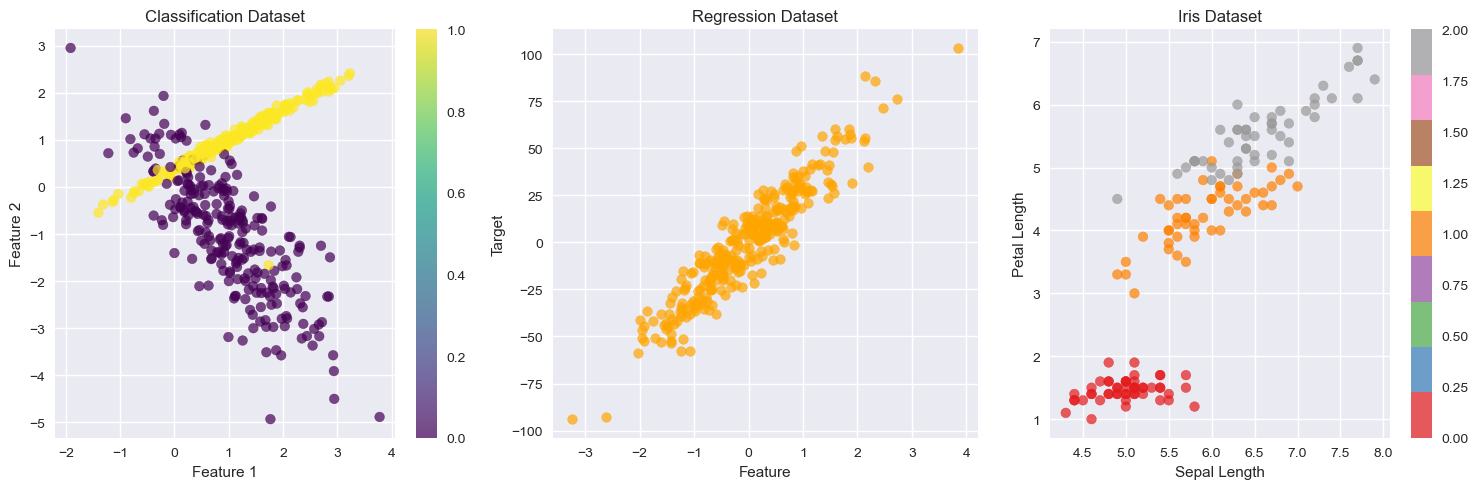

Iris dataset shape : (150, 3)
Species            : ['setosa' 'versicolor' 'virginica']


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Classification Dataset
print("🎯 Creating Classification Dataset")
X_cls, y_cls = make_classification( n_samples=500, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42)

# Create DataFrame
df_cls = pd.DataFrame({
    'feature_1' : X_cls[:, 0],
    'feature_2' : X_cls[:, 1],
    'target'    : y_cls
})

print(f"Classification dataset shape : {df_cls.shape}")
print(f"Classes                      : {np.unique(y_cls)}")
print(f"Class distribution           : {np.bincount(y_cls)}")

# Visualize classification data
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
scatter = plt.scatter(X_cls[:, 0], X_cls[:, 1], c=y_cls, cmap='viridis', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Dataset')
plt.colorbar(scatter)

# Regression Dataset
print("\n📈 Creating Regression Dataset")
X_reg, y_reg = make_regression( n_samples=300, n_features=1, noise=10, random_state=42)

df_reg = pd.DataFrame({
    'feature' : X_reg[:, 0],
    'target'  : y_reg
})

print(f"Regression dataset shape: {df_reg.shape}")

plt.subplot(1, 3, 2)
plt.scatter(X_reg, y_reg, alpha=0.7, color='orange')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Regression Dataset')

# Load Iris for detailed analysis
iris   = load_iris()
X_iris = iris.data[:, [0, 2]]  # Use only 2 features for visualization
y_iris = iris.target

df_iris = pd.DataFrame({
    'sepal_length': X_iris[:, 0],
    'petal_length': X_iris[:, 1],
    'species'     : y_iris
})

plt.subplot(1, 3, 3)
scatter = plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap='Set1', alpha=0.7)
plt.xlabel('Sepal Length')
plt.ylabel('Petal Length')
plt.title('Iris Dataset')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

print(f"Iris dataset shape : {df_iris.shape}")
print(f"Species            : {iris.target_names}")

## **🔧 4. Decision Tree from Scratch (Simplified)**

In [3]:
class DecisionTreeScratch:
    """
    Simplified Decision Tree implementation for binary classification
    """
    
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
    
    def gini_impurity(self, y):
        """Calculate Gini impurity"""
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def information_gain(self, X_column, y, threshold):
        """Calculate information gain for a split"""
        # Parent impurity
        parent_gini = self.gini_impurity(y)
        
        # Split data
        left_mask = X_column <= threshold
        right_mask = ~left_mask
        
        if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
            return 0
        
        # Weighted average of child impurities
        n = len(y)
        n_left, n_right = len(y[left_mask]), len(y[right_mask])
        left_gini = self.gini_impurity(y[left_mask])
        right_gini = self.gini_impurity(y[right_mask])
        
        child_gini = (n_left / n) * left_gini + (n_right / n) * right_gini
        
        return parent_gini - child_gini
    
    def find_best_split(self, X, y):
        """Find the best feature and threshold to split on"""
        best_gain = 0
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                gain = self.information_gain(X[:, feature_idx], y, threshold)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def build_tree(self, X, y, depth=0):
        """Recursively build the decision tree"""
        # Stopping criteria
        if (depth >= self.max_depth or 
            len(y) < self.min_samples_split or 
            len(np.unique(y)) == 1):
            
            # Return leaf node with majority class
            classes, counts = np.unique(y, return_counts=True)
            return classes[np.argmax(counts)]
        
        # Find best split
        feature, threshold, gain = self.find_best_split(X, y)
        
        if gain == 0:
            # No improvement, return leaf
            classes, counts = np.unique(y, return_counts=True)
            return classes[np.argmax(counts)]
        
        # Split data
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        
        # Recursively build subtrees
        left_subtree = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return {
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree
        }
    
    def fit(self, X, y):
        """Train the decision tree"""
        self.tree = self.build_tree(X, y)
        return self
    
    def predict_sample(self, x, tree):
        """Predict a single sample"""
        if not isinstance(tree, dict):
            return tree
        
        if x[tree['feature']] <= tree['threshold']:
            return self.predict_sample(x, tree['left'])
        else:
            return self.predict_sample(x, tree['right'])
    
    def predict(self, X):
        """Predict multiple samples"""
        return np.array([self.predict_sample(x, self.tree) for x in X])

# Test our implementation on binary classification
# Convert multiclass to binary for simplicity
y_binary = (y_cls == 1).astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_cls, y_binary, test_size=0.2, random_state=42)

# Train our model
tree_scratch = DecisionTreeScratch(max_depth=3)
tree_scratch.fit(X_train, y_train)

# Make predictions
y_pred_scratch = tree_scratch.predict(X_test)

print("🌳 Decision Tree from Scratch Results:")
print(f"Accuracy              : {accuracy_score(y_test, y_pred_scratch):.2f}")
print(f"Gini impurity of root : {tree_scratch.gini_impurity(y_train):.2f}")

🌳 Decision Tree from Scratch Results:
Accuracy              : 0.92
Gini impurity of root : 0.50


In [4]:
# Visualize our from-scratch tree using DOT format
print("🎨 Custom Tree Visualization")

def tree_to_dot(tree, feature_names=None, class_names=None):
    """Convert our custom tree to DOT format for graphviz visualization"""
    
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(10)]  # Default names
    if class_names is None:
        class_names = ["Class 0", "Class 1"]
    
    dot_string = "digraph Tree {\n"
    dot_string += "node [shape=box, style=\"filled,rounded\", fontname=arial];\n"
    dot_string += "edge [fontname=arial];\n"
    
    node_id = [0]  # Use list to make it mutable in nested function
    
    def add_node(tree, depth=0):
        """Recursively add nodes to DOT string"""
        current_id = node_id[0]
        node_id[0] += 1
        
        if not isinstance(tree, dict):  # Leaf node
            class_name = class_names[int(tree)]
            color = "#e6f3ff" if tree == 0 else "#ffe6e6"
            dot_string_local = f'{current_id} [label="{class_name}", fillcolor="{color}"];\n'
            return current_id, dot_string_local
        
        # Internal node
        feature_name = feature_names[tree['feature']]
        threshold = tree['threshold']
        
        # Node styling
        color = "#f0f0f0"
        label = f"{feature_name}\\n<= {threshold:.3f}"
        dot_string_local = f'{current_id} [label="{label}", fillcolor="{color}"];\n'
        
        # Process children
        left_id, left_dot = add_node(tree['left'], depth + 1)
        right_id, right_dot = add_node(tree['right'], depth + 1)
        
        # Add edges
        dot_string_local += f'{current_id} -> {left_id} [label="True"];\n'
        dot_string_local += f'{current_id} -> {right_id} [label="False"];\n'
        
        return current_id, dot_string_local + left_dot + right_dot
    
    try:
        _, tree_dot = add_node(tree)
        dot_string += tree_dot
        dot_string += "}"
        return dot_string
    except Exception as e:
        return f"Error creating DOT: {e}"

# Create DOT representation of our scratch tree
feature_names_binary = ['Feature 1', 'Feature 2']
class_names_binary   = ['Class 0', 'Class 1']

dot_data_scratch = tree_to_dot(
    tree_scratch.tree, 
    feature_names=feature_names_binary,
    class_names=class_names_binary
)

# Try to create graphviz visualization
try:
    scratch_graph = graphviz.Source(dot_data_scratch)
    print("\n✅ Custom tree visualization created successfully!")
    print("💡 This shows our from-scratch implementation in a professional format")
    
    # Could save the visualization
    # scratch_graph.render("scratch_tree", format="png", cleanup=True)
    
except Exception as e:
    print(f"\n⚠️ Graphviz rendering error: {e}")
    print("💡 The DOT format is correct, but graphviz package might need system installation")


# Split iris data
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

# Create and train scikit-learn decision tree
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train_iris, y_train_iris)
y_test_pred = clf.predict(X_test_iris)

# Compare tree complexities
print(f"\n📊 Tree Comparison:")
print(f"From-scratch tree depth: {3}")  # Our max_depth setting
print(f"Scikit-learn tree depth: {clf.tree_.max_depth}")
# Train a scikit-learn decision tree for comparison

print(f"From-scratch tree accuracy: {accuracy_score(y_test, y_pred_scratch):.3f}")
print(f"Scikit-learn tree accuracy: {accuracy_score(y_test_iris, y_test_pred):.3f}")

print(f"\n🎯 Key Benefits of export_graphviz + graphviz:")
print(f"✅ Professional publication-ready tree diagrams")
print(f"✅ Customizable colors, fonts, and styling")
print(f"✅ Multiple output formats (PNG, PDF, SVG)")
print(f"✅ Shows detailed node information (samples, impurity, etc.)")
print(f"✅ Works with both scikit-learn and custom tree implementations")

🎨 Custom Tree Visualization

✅ Custom tree visualization created successfully!
💡 This shows our from-scratch implementation in a professional format

📊 Tree Comparison:
From-scratch tree depth: 3
Scikit-learn tree depth: 3
From-scratch tree accuracy: 0.920
Scikit-learn tree accuracy: 0.967

🎯 Key Benefits of export_graphviz + graphviz:
✅ Professional publication-ready tree diagrams
✅ Customizable colors, fonts, and styling
✅ Multiple output formats (PNG, PDF, SVG)
✅ Shows detailed node information (samples, impurity, etc.)
✅ Works with both scikit-learn and custom tree implementations


## **🛠️ 5. Scikit-learn Implementation - Classification**

In [5]:
# Classification with Iris dataset
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.3, random_state=42)

# Create and train the model
clf = DecisionTreeClassifier( criterion='gini', max_depth=3, min_samples_split=5, random_state=42)

clf.fit(X_train_iris, y_train_iris)

# Make predictions
y_train_pred = clf.predict(X_train_iris)
y_test_pred  = clf.predict(X_test_iris)
y_test_proba = clf.predict_proba(X_test_iris)

print("🎯 Classification Results:")
print(f"Training Accuracy: {accuracy_score(y_train_iris, y_train_pred):.2f}")
print(f"Testing  Accuracy: {accuracy_score(y_test_iris, y_test_pred):.2f}")

print("\n📊 Feature Importance:")
feature_names = ['Sepal Length', 'Petal Length']
importances = clf.feature_importances_
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.2f}")

print("\n📋 Classification Report:")
print(classification_report(y_test_iris, y_test_pred, target_names=iris.target_names))

🎯 Classification Results:
Training Accuracy: 0.94
Testing  Accuracy: 0.98

📊 Feature Importance:
Sepal Length: 0.02
Petal Length: 0.98

📋 Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      0.92      0.96        13
   virginica       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45



## **📈 6. Scikit-learn Implementation - Regression**

In [6]:
# Regression with synthetic dataset
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Create and train the regression model
reg = DecisionTreeRegressor(criterion='squared_error',max_depth=5,min_samples_split=10,random_state=42)

reg.fit(X_train_reg, y_train_reg)

# Make predictions
y_train_pred_reg = reg.predict(X_train_reg)
y_test_pred_reg  = reg.predict(X_test_reg)

print("📈 Regression Results:")
print(f"Training R² Score : {r2_score(y_train_reg, y_train_pred_reg):.3f}")
print(f"Testing  R² Score : {r2_score(y_test_reg, y_test_pred_reg):.3f}")
print(f"Training RMSE : {np.sqrt(mean_squared_error(y_train_reg, y_train_pred_reg)):.3f}")
print(f"Testing  RMSE : {np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg)):.3f}")
print(f"Testing MAE : {mean_absolute_error(y_test_reg, y_test_pred_reg):.3f}")

📈 Regression Results:
Training R² Score : 0.918
Testing  R² Score : 0.834
Training RMSE : 8.217
Testing  RMSE : 13.081
Testing MAE : 9.956


## **📊 7. Visualizations and Model Interpretation**

🌳 Decision Tree Rules:
|--- Petal Length <= 2.45
|   |--- class: 0
|--- Petal Length >  2.45
|   |--- Petal Length <= 4.75
|   |   |--- Sepal Length <= 4.95
|   |   |   |--- class: 1
|   |   |--- Sepal Length >  4.95
|   |   |   |--- class: 1
|   |--- Petal Length >  4.75
|   |   |--- Petal Length <= 5.15
|   |   |   |--- class: 2
|   |   |--- Petal Length >  5.15
|   |   |   |--- class: 2



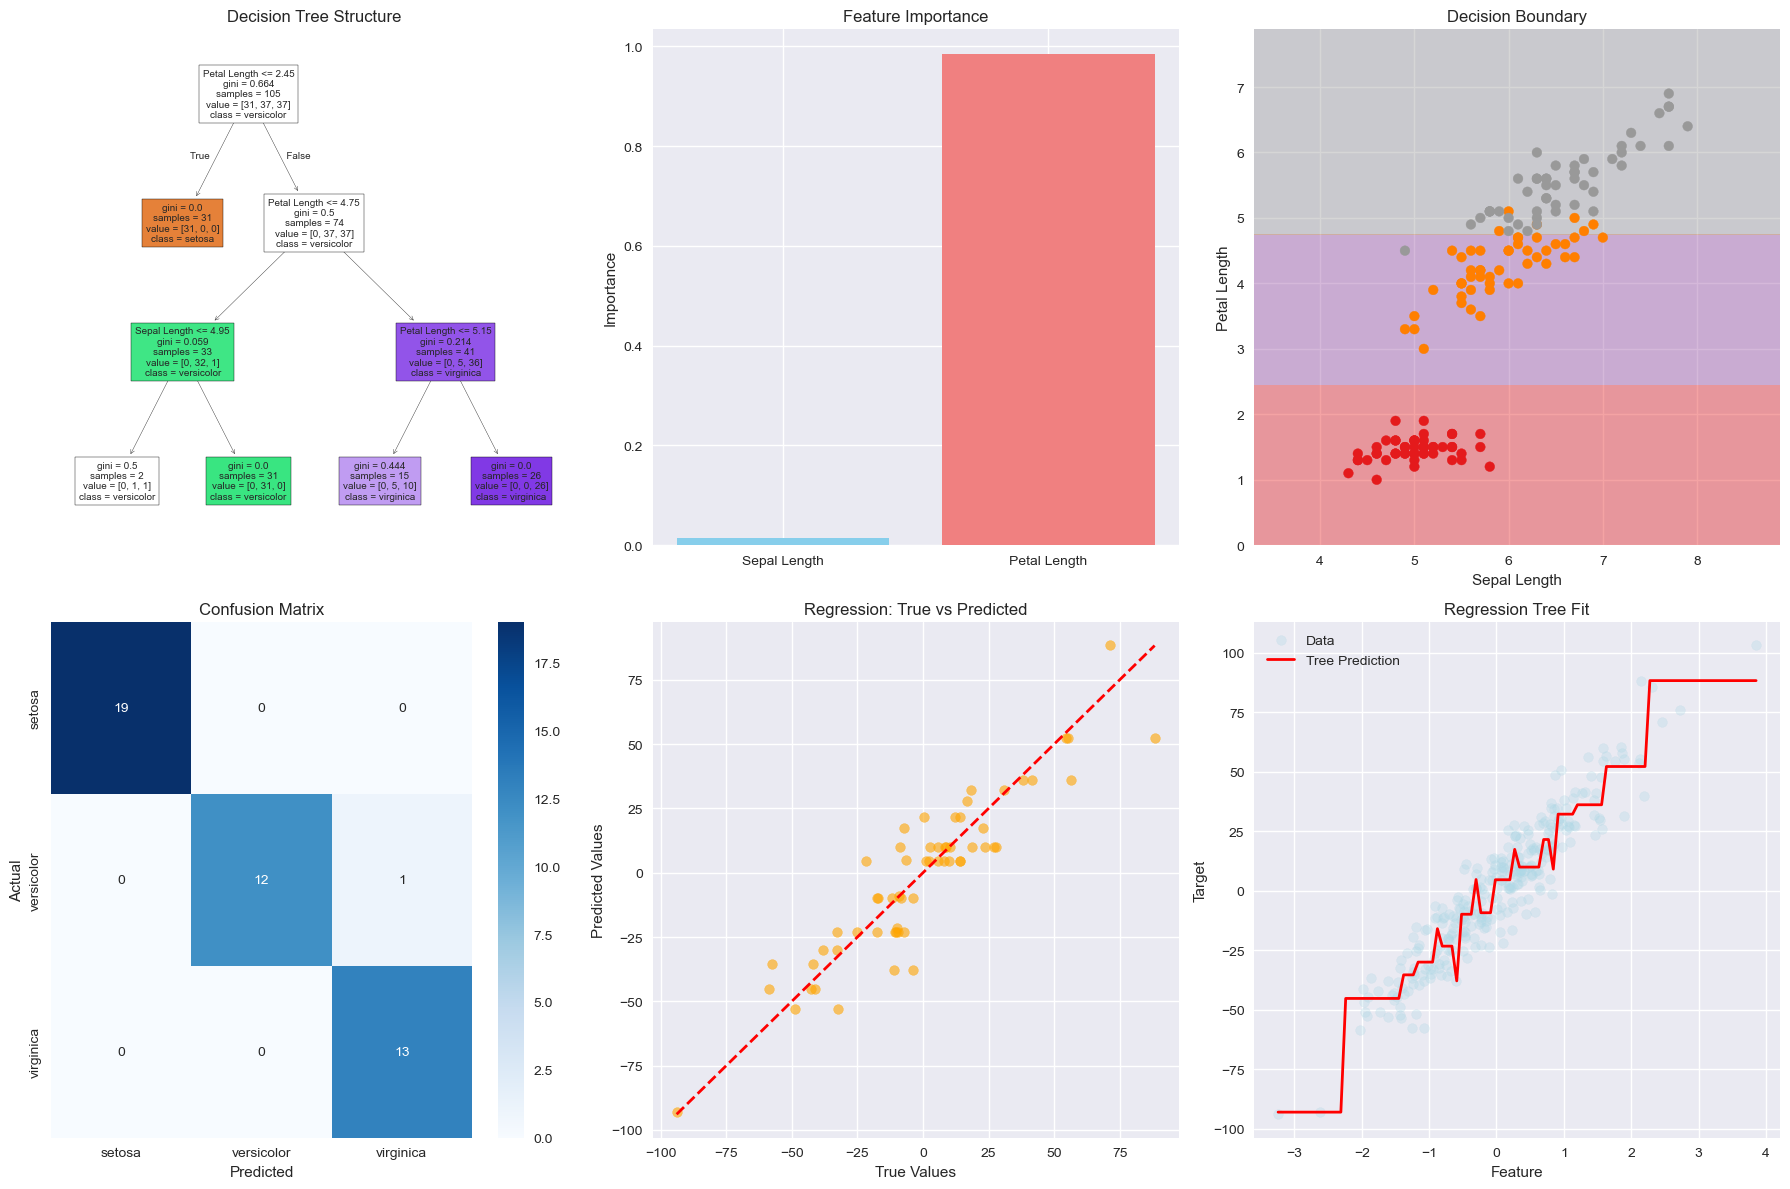

In [7]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Decision Tree Structure (Text)
tree_rules = export_text(clf, feature_names=feature_names)
print("🌳 Decision Tree Rules:")
print(tree_rules)

# 2. Tree Visualization
plot_tree(clf,  feature_names=feature_names, class_names=iris.target_names, filled=True, ax=axes[0, 0])
axes[0, 0].set_title('Decision Tree Structure')

# 3. Feature Importance
axes[0, 1].bar(feature_names, importances, color=['skyblue', 'lightcoral'])
axes[0, 1].set_title('Feature Importance')
axes[0, 1].set_ylabel('Importance')

# 4. Decision Boundary for Classification
h = 0.02
x_min, x_max = X_iris[:, 0].min() - 1, X_iris[:, 0].max() + 1
y_min, y_max = X_iris[:, 1].min() - 1, X_iris[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axes[0, 2].contourf(xx, yy, Z, alpha=0.4, cmap='Set1')
scatter = axes[0, 2].scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap='Set1')
axes[0, 2].set_xlabel('Sepal Length')
axes[0, 2].set_ylabel('Petal Length')
axes[0, 2].set_title('Decision Boundary')

# 5. Confusion Matrix
cm = confusion_matrix(y_test_iris, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],xticklabels=iris.target_names, yticklabels=iris.target_names)
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Confusion Matrix')

# 6. Regression Predictions
axes[1, 1].scatter(y_test_reg, y_test_pred_reg, alpha=0.6, color='orange')
axes[1, 1].plot([y_test_reg.min(), y_test_reg.max()],  [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('True Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title('Regression: True vs Predicted')

# 7. Regression Tree Predictions
X_plot = np.linspace(X_reg.min(), X_reg.max(), 100).reshape(-1, 1)
y_plot = reg.predict(X_plot)
axes[1, 2].scatter(X_reg, y_reg, alpha=0.3, color='lightblue', label='Data')
axes[1, 2].plot(X_plot, y_plot, color='red', linewidth=2, label='Tree Prediction')
axes[1, 2].set_xlabel('Feature')
axes[1, 2].set_ylabel('Target')
axes[1, 2].set_title('Regression Tree Fit')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

## **⚖️ 8. Bias-Variance Analysis and Overfitting**

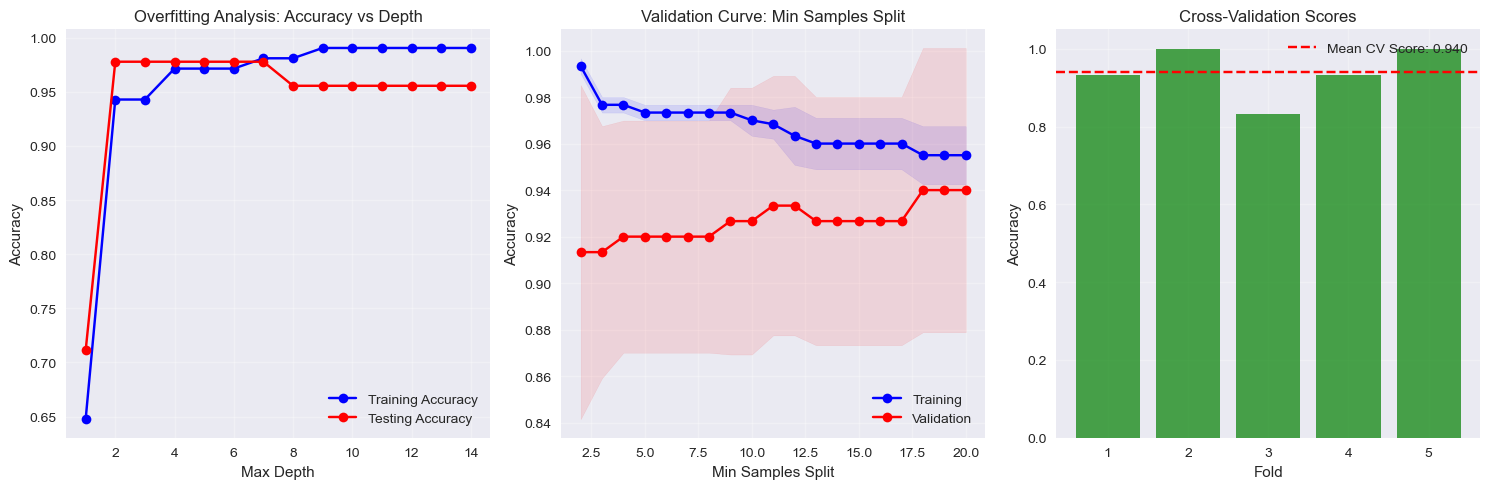

📊 Cross-Validation Results:
CV Scores     : [0.93333333 1.         0.83333333 0.93333333 1.        ]
Mean CV Score : 0.940 (+/- 0.122)


In [8]:
# Analyze the effect of tree depth on performance
depths = range(1, 15)
train_scores = []
test_scores  = []

for depth in depths:
    # Create model with specific depth
    clf_depth = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf_depth.fit(X_train_iris, y_train_iris)
    
    # Calculate scores
    train_score = clf_depth.score(X_train_iris, y_train_iris)
    test_score  = clf_depth.score(X_test_iris, y_test_iris)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

# Plot learning curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(depths, train_scores, 'o-', label='Training Accuracy', color='blue')
plt.plot(depths, test_scores, 'o-', label='Testing Accuracy', color='red')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Overfitting Analysis: Accuracy vs Depth')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation curve for min_samples_split
train_scores_ms, test_scores_ms = validation_curve( DecisionTreeClassifier(random_state=42), X_iris, y_iris, param_name='min_samples_split', param_range=range(2, 21), cv=5, scoring='accuracy')

plt.subplot(1, 3, 2)
plt.plot(range(2, 21), train_scores_ms.mean(axis=1), 'o-', label='Training', color='blue')
plt.plot(range(2, 21), test_scores_ms.mean(axis=1), 'o-', label='Validation', color='red')
plt.fill_between(range(2, 21), 
                train_scores_ms.mean(axis=1) - train_scores_ms.std(axis=1),
                train_scores_ms.mean(axis=1) + train_scores_ms.std(axis=1),
                alpha=0.1, color='blue')
plt.fill_between(range(2, 21), 
                test_scores_ms.mean(axis=1) - test_scores_ms.std(axis=1),
                test_scores_ms.mean(axis=1) + test_scores_ms.std(axis=1),
                alpha=0.1, color='red')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.title('Validation Curve: Min Samples Split')
plt.legend()
plt.grid(True, alpha=0.3)

# Cross-validation scores
cv_scores = cross_val_score(clf, X_iris, y_iris, cv=5, scoring='accuracy')

plt.subplot(1, 3, 3)
plt.bar(range(1, 6), cv_scores, color='green', alpha=0.7)
plt.axhline(cv_scores.mean(), color='red', linestyle='--', label=f'Mean CV Score: {cv_scores.mean():.3f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Cross-Validation Results:")
print(f"CV Scores     : {cv_scores}")
print(f"Mean CV Score : {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

## **🎯 9. Key Hyperparameters and Tuning**

🎛️ Key Decision Tree Hyperparameters:

1. max_depth : Maximum depth of the tree
   - Controls overfitting
   - Default         : None (unlimited)
   - Typical range   : 3-10

2. min_samples_split : Minimum samples required to split a node
   - Prevents overfitting
   - Default         : 2
   - Typical range   : 2-20

3. min_samples_leaf : Minimum samples required at a leaf node
   - Smoothens the model
   - Default         : 1
   - Typical range   : 1-10

4. max_features : Number of features to consider for best split
   - Reduces overfitting
   - Options         : 'sqrt', 'log2', None, int, float

5. criterion: Function to measure split quality
   - Classification  : 'gini', 'entropy'
   - Regression      : 'squared_error', 'absolute_error'

6. random_state : Controls randomness
   - For reproducibility


🔍 Comparing Different Criteria:
Gini    Criterion Accuracy : 0.978
Entropy Criterion Accuracy : 0.978


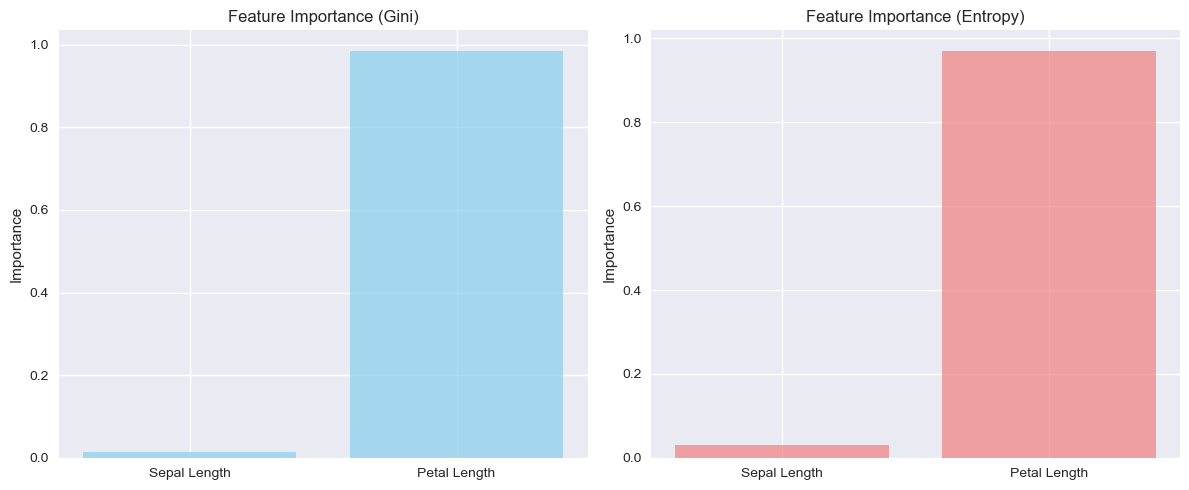

In [9]:
# Demonstrate key hyperparameters
print("🎛️ Key Decision Tree Hyperparameters:")
print("""
1. max_depth : Maximum depth of the tree
   - Controls overfitting
   - Default         : None (unlimited)
   - Typical range   : 3-10

2. min_samples_split : Minimum samples required to split a node
   - Prevents overfitting
   - Default         : 2
   - Typical range   : 2-20

3. min_samples_leaf : Minimum samples required at a leaf node
   - Smoothens the model
   - Default         : 1
   - Typical range   : 1-10

4. max_features : Number of features to consider for best split
   - Reduces overfitting
   - Options         : 'sqrt', 'log2', None, int, float

5. criterion: Function to measure split quality
   - Classification  : 'gini', 'entropy'
   - Regression      : 'squared_error', 'absolute_error'

6. random_state : Controls randomness
   - For reproducibility
""")

# Compare different criteria
print("\n🔍 Comparing Different Criteria:")

# Gini vs Entropy
clf_gini    = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

clf_gini.fit(X_train_iris, y_train_iris)
clf_entropy.fit(X_train_iris, y_train_iris)

gini_score    = clf_gini.score(X_test_iris, y_test_iris)
entropy_score = clf_entropy.score(X_test_iris, y_test_iris)

print(f"Gini    Criterion Accuracy : {gini_score:.3f}")
print(f"Entropy Criterion Accuracy : {entropy_score:.3f}")

# Feature importance comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(feature_names, clf_gini.feature_importances_, color='skyblue', alpha=0.7)
plt.title('Feature Importance (Gini)')
plt.ylabel('Importance')

plt.subplot(1, 2, 2)
plt.bar(feature_names, clf_entropy.feature_importances_, color='lightcoral', alpha=0.7)
plt.title('Feature Importance (Entropy)')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()

## **✅ 10. Advantages and Disadvantages**

### **Advantages:** ✅

1. **Easy to Understand**: Visual and intuitive representation
2. **No Data Preprocessing**: Handles both numerical and categorical data
3. **Feature Selection**: Automatically selects relevant features
4. **Non-linear Relationships**: Can capture complex patterns
5. **Missing Values**: Can handle missing values naturally
6. **Fast Training**: Relatively quick to train
7. **Feature Importance**: Provides feature importance scores

### **Disadvantages:** ❌

1. **Overfitting**: Prone to overfitting, especially with deep trees
2. **Instability**: Small changes in data can result in very different trees
3. **Bias**: Biased toward features with more levels
4. **Linear Relationships**: May not perform well with linear relationships
5. **Imbalanced Data**: Can be biased toward dominant classes
6. **High Variance**: High variance in predictions

### **When to Use Decision Trees:** 🎯

- **Interpretability is important**: When you need to explain decisions
- **Mixed data types**: When you have both numerical and categorical features
- **Non-linear patterns**: When relationships are non-linear
- **Feature selection**: When you want automatic feature selection
- **Baseline model**: As a starting point for more complex models

### **When NOT to Use:** ⚠️

- **Linear relationships**: When relationships are primarily linear
- **High-dimensional data**: With many features (curse of dimensionality)
- **Stable predictions needed**: When consistency is more important than interpretability
- **Continuous smooth functions**: When the underlying function is smooth

## **🔍 11. Real-World Example: Predicting Customer Churn**

📊 Customer Churn Dataset:
Dataset shape : (1000, 7)
Churn rate    : 23.4%

First 5 customers:


,age,monthly_charges,total_charges,tenure_months,support_calls,contract_type,churn
0,40.960570,92.987109,1324.821725,54,0,1,0
1,33.340828,83.492674,1855.481329,28,2,0,1
2,42.772262,66.192607,1207.580079,58,0,2,0
3,53.276358,52.061264,1692.038470,30,3,0,1
4,32.190160,78.964466,106.385333,9,1,1,0



🎯 Churn Prediction Results:
Accuracy  : 0.720
Precision : 0.355
Recall    : 0.234

📊 Feature Importance for Churn Prediction:


,Feature,Importance
5,contract_type,0.418026
1,monthly_charges,0.188086
2,total_charges,0.166117
3,tenure_months,0.105153
4,support_calls,0.083612
0,age,0.039006


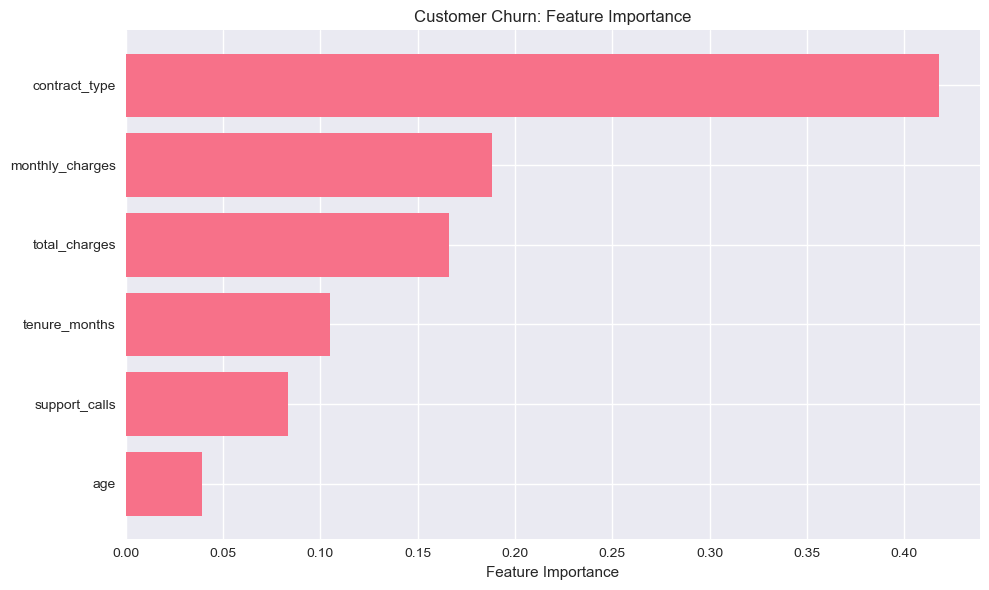

In [10]:
# Create a realistic customer churn dataset
np.random.seed(42)
n_customers = 1000

# Generate customer features
data = {
    'age': np.random.normal(35, 12, n_customers),
    'monthly_charges': np.random.normal(65, 20, n_customers),
    'total_charges'  : np.random.normal(2000, 1000, n_customers),
    'tenure_months'  : np.random.randint(1, 61, n_customers),
    'support_calls'  : np.random.poisson(2, n_customers),
    'contract_type'  : np.random.choice([0, 1, 2], n_customers, p=[0.4, 0.3, 0.3])  # 0: month-to-month, 1: 1-year, 2: 2-year
}

# Create target variable with realistic relationships
churn_probability = (
    0.1 +  # base probability
    0.15 * (data['monthly_charges'] > 80) +  # high charges increase churn
    0.2 * (data['support_calls'] > 3) +      # many support calls increase churn
    0.25 * (data['contract_type'] == 0) +    # month-to-month contracts increase churn
    0.1 * (data['tenure_months'] < 6) -      # new customers more likely to churn
    0.1 * (data['tenure_months'] > 24)       # long-term customers less likely to churn
)

# Add some randomness
churn_probability += np.random.normal(0, 0.1, n_customers)
churn_probability = np.clip(churn_probability, 0, 1)

# Generate binary churn labels
churn = (np.random.random(n_customers) < churn_probability).astype(int)

# Create DataFrame
customer_df = pd.DataFrame(data)
customer_df['churn'] = churn

print("📊 Customer Churn Dataset:")
print(f"Dataset shape : {customer_df.shape}")
print(f"Churn rate    : {churn.mean():.1%}")
print("\nFirst 5 customers:")
display(customer_df.head())

# Prepare features
feature_columns = ['age', 'monthly_charges', 'total_charges', 'tenure_months', 'support_calls', 'contract_type']
X_customer = customer_df[feature_columns]
y_customer = customer_df['churn']

# Split data
X_train_cust, X_test_cust, y_train_cust, y_test_cust = train_test_split(X_customer, y_customer, test_size=0.2, random_state=42, stratify=y_customer)

# Train decision tree
churn_tree = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

churn_tree.fit(X_train_cust, y_train_cust)

# Make predictions
y_pred_cust = churn_tree.predict(X_test_cust)
y_proba_cust = churn_tree.predict_proba(X_test_cust)[:, 1]

print("\n🎯 Churn Prediction Results:")
print(f"Accuracy  : {accuracy_score(y_test_cust, y_pred_cust):.3f}")
print(f"Precision : {precision_score(y_test_cust, y_pred_cust):.3f}")
print(f"Recall    : {recall_score(y_test_cust, y_pred_cust):.3f}")

print("\n📊 Feature Importance for Churn Prediction:")
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': churn_tree.feature_importances_
}).sort_values('Importance', ascending=False)

display(feature_importance_df)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Customer Churn: Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## **📝 12. Summary and Key Takeaways**

### **Decision Trees in a Nutshell:** 🌰

Decision Trees are powerful, interpretable machine learning algorithms that work by recursively splitting data based on feature values to create a tree-like model of decisions.

### **Key Points to Remember:** 💡

1. **Interpretability**: One of the most interpretable ML algorithms
2. **No Preprocessing**: Works with raw data (numerical and categorical)
3. **Automatic Feature Selection**: Identifies important features automatically
4. **Overfitting Risk**: Prone to overfitting; use pruning techniques
5. **Instability**: Small data changes can create very different trees
6. **Foundation**: Forms the basis for ensemble methods (Random Forest, XGBoost)

### **Best Practices:** 🎯

1. **Start Simple**: Begin with shallow trees (max_depth=3-5)
2. **Cross-Validate**: Always use cross-validation for hyperparameter tuning
3. **Prune Carefully**: Use min_samples_split and min_samples_leaf to prevent overfitting
4. **Ensemble Methods**: Consider Random Forest or XGBoost for better performance
5. **Visualize**: Always visualize your trees to understand the decision process

### **Next Steps:** 🚀

- **Random Forest**: Learn ensemble methods for better performance
- **XGBoost**: Explore gradient boosting for even better results
- **Feature Engineering**: Improve your features for better tree performance
- **Hyperparameter Tuning**: Use GridSearch or RandomSearch for optimal parameters

Decision Trees are an excellent starting point for machine learning projects due to their interpretability and ease of use. While they may not always achieve the highest accuracy, they provide valuable insights into your data and serve as the foundation for more advanced ensemble methods! 🌳✨